<center>
    <h1>Diabetic Retinopathy Detection</h1>
    <h2>Final Report</h2>
    <h3>Omer Cinal</h3>
    <img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4104/logos/front_page.png">
    <h2>Introduction</h2>
    <div>
        Diabetic retinopathy is a complication that affects the eyes and is caused by diabetes. The tissue at the back of the eye (retina) is damaged slowly. The disease usually shows no symptoms and only causes mild visual problems. As the illness progresses, the eye starts losing vision rapidly. Diabetic retinopathy is one of the leading causes of blindess. It is estimated that 347 million people around the world carry the disease. 
    </div>
    <br>
    <div>
        This is a Kaggle competition. More details can be found following the link below.<br>
        https://www.kaggle.com/c/diabetic-retinopathy-detection
    </div>


<h2>Metrics Used</h2>
    - Accuracy
    - Precision
    - Recall
    - F1
    - Confusion Matrix
    - Cohens Kappa

<h2>Outline</h2>
- Libraries <a href=#Libraries>Go</a>
- Data Exploration <a href=#Data-Exploration>Go</a>
- Preprocessing <a href=#Preprocessing>Go</a>
- Classification <a href=#Classification>Go</a>
- Conclusion <a href=#Conclusion>Go</a>

<h2>Libraries</h2><a href=#Outline>Go Up</a>
<h3>Data processing</h3>
The following libraries are used for preparing the data for training the models.
- Opencv
- PIL
- Pandas

<h3>Classifiers</h3>
The following libraries are used for classification.
- Sklearn
    - Support Vector Classifier   (SVC)
    - Stochastic Gradient Descent (SGD)
    - Random Forest Classifier    (RFC)
    - Ada Boost Classifier        (ADA)
    - Logistic Regression         (LR)
- Keras
    - Tensorflow

<h3>Visualization</h3>
- Matplotlib
- Plotly

In [1]:
from IPython.display import HTML, display
from PIL import Image
import os
import pandas as pd
import numpy as np
import cv2
import keras
import time
import math
from operator import mul

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Using Tensorflow backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution1D, MaxPooling1D
from keras.utils import np_utils

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import plotly
plotly.tools.set_credentials_file(username='omerci', api_key='lo3FuhJKiCE9Dxvg8nye') 

np.random.seed(42)

MYPATH = os.getcwd()
IMAGE_PATH = MYPATH + "/train"
SCALED_IMAGE_PATH = MYPATH + "/train_rescaled_256"
PAIR_PATH = MYPATH + "/train_pairs"
PAIR_PATH_RGB = MYPATH + "/train_pairs_rgb"
TEST_RATIO = 0.20
RESOLUTION = (256, 256) 
LABEL_COUNT = 5

Using TensorFlow backend.


The code below gets the image sizes one by one and plots them.

In [2]:
# Goes through the folder and gets the image sizes
def getImageSizes(files, resolution=None, show_progress=False):
    hist = dict()
    i=0
    s = len(files)
    print "Total Image count:",s
    for image in files:
        if show_progress:
            i += 1
            if i % 1000 == 0: print (i*1.0)/s 
        imsize = Image.open("train/" + image).size
        if resolution:
            if imsize != resolution: 
                continue  
        if imsize not in hist:
            hist[imsize] = 1
        else:
            hist[imsize] += 1
    print "Fitting image count:", sum(hist.values())
    return hist

# Plots the image sizes in a readable plot
def plotImageSizes(image_sizes):
    sorted_keys = sorted(image_sizes.keys())
    image_sizes_keys = [("%04d x %04d" % (j, i)) for i, j in sorted_keys]
    image_sizes_values = [image_sizes[i] for i in sorted_keys]
    plt.figure(figsize=(15, 10))
    plt.xlabel("Resolution", fontsize=50)
    plt.ylabel("# of images", fontsize=50)
    plt.xticks(rotation="vertical", fontsize=30)
    plt.yticks(fontsize=30)
    plt.bar(image_sizes_keys, image_sizes_values)
    #plt.savefig("Image_sizes.png")
    return plt.show()

<h1>Data Exploration</h1><a href=#Outline>Go Up</a><br>
The first step I took was to figure out what properties the data had. Below, it can been seen that the training dataset contains 35126 single eye images. And each image looks like this.
<center><table>
    <tr>
    <td><img src="https://preview.ibb.co/cLJ7nG/10_left.jpg"></td>
    <td><img src="https://preview.ibb.co/cbKDSG/10_right.jpg"></td>
    </tr>
    <td>10_left.jpeg</td>
    <td>10_right.jpeg</td>
</table>
</center>
Even though each eye is in a separate file, diabetic retinapathy affects both eyes in almost all conditions. So merging eyes into one image should help manipulating the data and maybe increase the accuracy. <br><br>
Second, images vary in resolution.

<h3>Resolution</h3>

In [ ]:
# reading the images names from the label file
names = pd.read_csv("trainLabels.csv")["image"]
# getting the resolution of each image file by file
image_sizes = getImageSizes(names)
# plotting the sizes
plotImageSizes(names) 

Total image count is how many images there are in the folder and fitting image count is how many of them match the labels. This is done to ensure there are no mistakes in labeling the data.

The figure below is the histogram of resolutions. The images are in high quality and their resolutions vary a lot.
<img src="https://preview.ibb.co/hsz2Mb/Image_sizes.png">
<br>
Even though the needed part of the image is circular (retina), the images are mostly not even close to being square shaped. This is caused by the black edges mostly on the left and right sides. These mean the images should be rescaled to a much smaller resolution and black edges must be cropped to avoid image disruption.

<img src="https://preview.ibb.co/iPoJuw/cropping_black_edges.png">

<h3>Class Distribution</h3>
Diabetic retinopathy has 4 stages. So, there are 5 labels in total including control group images.
- (0) No DR
- (1) Mild 
- (2) Moderate 
- (3) Severe 
- (4) Proliferative DR  

<center><table>
    <tr>
    <td><img src="https://image.ibb.co/fO6hMb/10_rescaled_256.jpg"></td>
    <td><img src="https://image.ibb.co/jVAnnG/36_rescaled_256.jpg"></td>
    <td><img src="https://image.ibb.co/d58wgb/51_rescaled_256.jpg"></td>
    <td><img src="https://image.ibb.co/eFMtSG/99_rescaled_256.jpg"></td>
    <td><img src="https://image.ibb.co/cLOjZw/294_rescaled_256.jpg"></td>
    </tr>
    <td>NO DR</td>
    <td>Mild</td>
    <td>Moderate</td>
    <td>Severe</td>
    <td>Proliferative</td>
</table>
</center>
(The black edges are cropped and images are rescaled to 256x256 in the images above) <br>

Plotting a histogram of the dataset showed that labels are very unbalanced.

In [4]:
# reading labels from the labels file
labels = pd.read_csv("trainLabels.csv")
image_names = labels["image"]
labels = labels["level"]

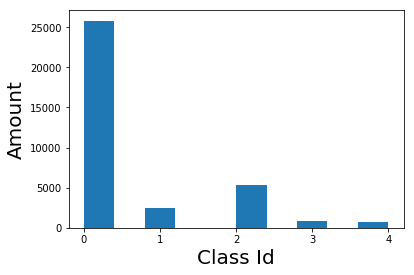

In [4]:
plt.hist(labels, align="mid")
plt.xticks(range(5))
plt.xlabel("Class Id", fontsize=20)
plt.ylabel("Amount", fontsize=20)
plt.show() 

73.47% of the data is the control group. This causes a big problem since it will affect the accuracy of the classifiers and should be solved. However, I have yet address a method on solving this problem.
Removing 50% of the control group is the quickest solution so far. This hasn't been implemented yet.

<h3>Order of the labels</h3>

The images are pre-shuffled. The labels for each image is shown below, there are no clusters of labels. This will come in handy when selecting a small subset of the dataset for training and testing the classifiers. There is no need for random selection. 

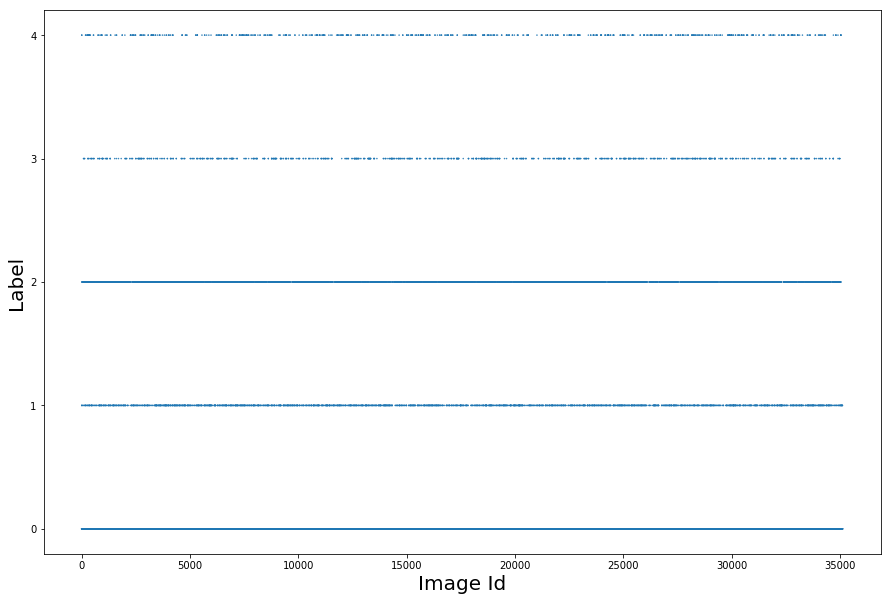

In [29]:
plt.figure(figsize=(15, 10))
plt.yticks(range(5))
plt.xlabel("Image Id", fontsize=20)
plt.ylabel("Label", fontsize=20)
plt.scatter(range(35126), labels, marker=".",s=[1 for i in range(35126)])
plt.show()

<h1>Preprocessing</h1><a href=#Outline>Go Up</a><br>

The raw image is processed with the following steps. First the images are read using Opencv library. The files are in jpeg format. This means they are compressed and occupy less space. But, this also means there will be loss of data if they are saved as jpeg after rescaling. So, the images are saved using numpy library as npy files.  

<img src="https://preview.ibb.co/gbN07G/preprocessing_pipeline.png">
<center><table>
    <tr>
    <td><img height=256 width= 256 src="https://preview.ibb.co/cLJ7nG/10_left.jpg"></td>
    <td><img src="https://image.ibb.co/mOSWgb/10_pair_rgb.png"></td>
    <td><img src="https://image.ibb.co/nPQv7G/10_stacked.png"></td>
    </tr>
    <td>Raw Image (4758 x 3168 x 3)</td>
    <td>RGB Image (512 x 256 x 3)</td>
    <td>*Stacked RGB Image (768 x 512)</td>
</table>
</center>

*The stacked RGB image appears greenish because of the way matplotlib displays 1D images. 

There are 2 outputs of the preprocessing pipeline. This is done for testing purposes. Images are also converted into grayscale, however, there was an apparent loss of features due to conversion. 

<h3>Cropping & Resizing</h3>

The black edges are detected using numpy library's masking feature. A black pixel contains the number 0, so for the mask a threshold value of 1 should be enough. However, some images are noisy and sometimes black areas contain lighter pixels. So, by testing a threshold of 10 is used to create a mask that will crop out the edges.

After cropping the edges the images become square shaped (or close to a square). So downscaling won't disrupt the image. Opencv library resizes the images to 256 x 256 pixels.

In [5]:
# Crops the black edges and rescales an image
def resizeImage(img_name, threshold=10):
    img = cv2.imread(img_name)
    mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  > threshold
    img = img[np.ix_(mask.any(1), mask.any(0))]
    return cv2.resize(img, RESOLUTION)

The images are processed one by one. This step takes around 2 hours. So, this part is done using multithreading in another file. By utilizing 8 cores, this operation takes less than 30 minutes. The limitation after the CPU utilization seems to be the hard drive not being able to cache up. 

In [6]:
# Resizes and saves each image
def resizeAndSaveImages(img_names, start, destination, resolution=RESOLUTION, threshold=10):
    i=0
    for name in img_names:
        name = ".".join([name, 'jpeg'])
        img = Image.fromarray(resizeImage(start+"/"+name))
        img.save(destination+"/"+name)
        i+=1
        if i%3500 == 0:
            print i,
    print "Done"

In [5]:
#resizeAndSaveImages(image_names, "train", "train_rescaled_256")

<h3>Merging Eyes</h3>

The ids of images are extracted. Since left and right pairs will be merged, name extensions like "10_left" are no longer required. 

In [7]:
# Merges left and right pair names
def mergeRightLeft(img_names, labels):
    X, y = [], []
    for i in range(0, len(img_names)-1, 2):
        X.append(img_names[i].split("_")[0]+".npy")
        y.append(labels[i])
    return X, y

# Merges left and right pair images and saves them 
def makePairImages(pairs):
    for name in pairs:
        name = PAIR_PATH+"/"+name.split("_")[0]+".jpeg"
        left = cv2.imread(SCALED_IMAGE_PATH+"/"+i+"_left.jpeg")
        right = cv2.imread(SCALED_IMAGE_PATH+"/"+i+"_right.jpeg")
        Image.fromarray(np.concatenate((left, right), axis=1)).save(name)

So, at this point images look like this. They are ready to train the models.

<img src="https://image.ibb.co/mOSWgb/10_pair_rgb.png">

<h3>Train & Test sets</h3>

Here, the train and the test sets are splitted with a ratio of 0.2. The test set ratio is low since the dataset is relatively large. Sklearn library is used for splitting the data.

In [8]:
def splitTrainTest(X, y, ratio=TEST_RATIO):
    return train_test_split(X, y, test_size=ratio)

In [9]:
X, y = mergeRightLeft(image_names, labels)
X_train, X_test, y_train, y_test = splitTrainTest(X, y)
#makePairImages(X)

Preparing another label file for health vs sick classification attempts

In [50]:
def binarizeArray(y):
    y_train_ovr = np.array(y) 
    for i, e in enumerate(y_train_ovr):
        if e != 0:
            y_train_ovr[i] = 1
    return y_train_ovr

y_train_ovr = binarizeArray(y)  

<h4>Under and Over sampling</h4>
The dataset is undersampled and oversampled to fix the imbalance problem. This method is selected since it is easy to implement and since the dataset is big enough, it is unlikely to cause any loss on the significant data points.

I have compared both methods to see which one would give me a better result in classification.

In [52]:
# Random states are not changed since numpy seed is set to 42
# Under sampler
rus = RandomUnderSampler()
X_us, y_us = rus.fit_sample(np.reshape(X, (-1, 1)), y) 
X_trainus, X_testus, y_trainus, y_testus = splitTrainTest(X_us, y_us) 

# Binarized
X_us_bin, y_us_bin = rus.fit_sample(np.reshape(X, (-1, 1)), binarizeArray(y))
X_trainus_bin, X_testus_bin, y_trainus_bin, y_testus_bin = splitTrainTest(X_us_bin, y_us_bin)

# Over sampler
ros = RandomOverSampler()
X_os, y_os = ros.fit_sample(np.reshape(X, (-1, 1)), y) 
X_trainos, X_testos, y_trainos, y_testos = splitTrainTest(X_os, y_os) 

# Binarized
X_os_bin, y_os_bin = ros.fit_sample(np.reshape(X, (-1, 1)), binarizeArray(y))
X_trainos_bin, X_testos_bin, y_trainos_bin, y_testos_bin = splitTrainTest(X_os_bin, y_os_bin) 

Original sampling train set count 14050, test set count 3513.

Random over sampling train set count 1412, test set count 12871.

Random under sampling train set count 1412, test set count 353.


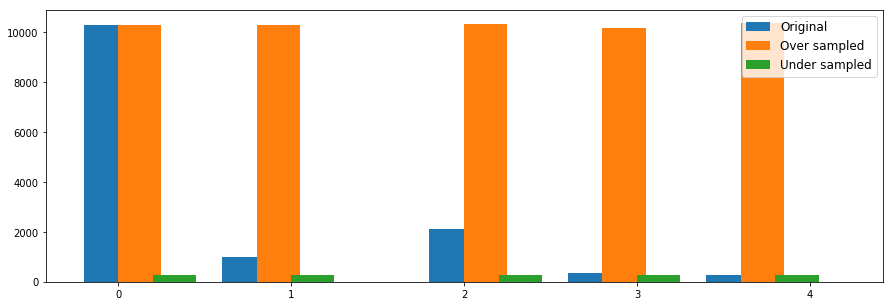

In [53]:
print '''Original sampling train set count {0}, test set count {1}.\n
Random over sampling train set count {4}, test set count {5}.\n
Random under sampling train set count {2}, test set count {3}.'''\
        .format(len(y_train), len(y_test), len(y_trainus), len(y_testus), len(y_trainus), len(y_testos)) 
plt.figure(figsize=(15, 5)) 
plt.hist(y_train, align='left', label='Original', width=0.25)
plt.hist(y_trainos, align='mid', label='Over sampled', width=0.25)
plt.hist(y_trainus, align='right', label='Under sampled', width=0.25)
plt.legend(prop={'size':12}) 
plt.show() 

Original data is highly imbalanced on the label 0.
Over sampled data seems to be the most uniformly distributed. I will be using it as my training and test set.
Under sampled data is also uniformly distributed but the sample size is very small. Could still be used.

Original sampling train set count 14050, test set count 3513.

Random over sampling train set count 7507, test set count 5149.

Random under sampling train set count 7507, test set count 1877.


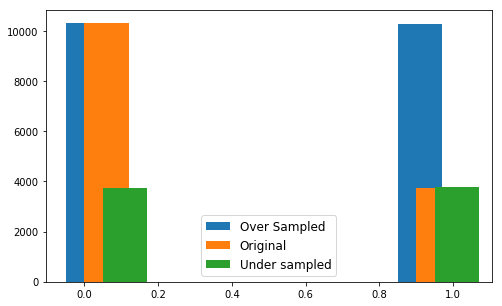

In [59]:
print '''Original sampling train set count {0}, test set count {1}.\n
Random over sampling train set count {4}, test set count {5}.\n
Random under sampling train set count {2}, test set count {3}.'''\
        .format(len(y_train), len(y_test), len(y_trainus_bin), len(y_testus_bin), len(y_trainus_bin), len(y_testos_bin))
plt.figure(figsize=(8, 5)) 
plt.hist(y_trainos_bin, align='left', label='Over Sampled', width=0.12)
plt.hist(binarizeArray(y_train), align='mid', label='Original', width=0.12)
plt.hist(y_trainus_bin, align='right', label='Under sampled', width=0.12)
plt.legend(prop={'size':12}) 
plt.show() 

Binarized data seems to have a larger test size, since all labels are merged.

<h3>PCA</h3>
PCA will be applied when the train funcion is called and images are loaded on the memory.

To find out what should be the n_components be for around 95% information preservence, I tried to do eigendecomposition and plotted them to see the variance each principal component carries. 

In [12]:
def applyPCA(X, n_components=None):
    clf = PCA(n_components=n_components)  
    return clf.fit_transform(X) 

In [209]:
names = X_trainus[:5]
images = [None for i in range(len(names))]
for i in range(len(names)):
    images[i] = np.load(PAIR_PATH+"/"+names[i][0]).flatten()
    
print 'Original sample dimensions {}'.format(images[0].shape)
sample = applyPCA(images)   
print 'Sample dimensions after PCA {}'.format(sample[0].shape) 

Original sample dimensions (393216,)
	Applying PCA with None components ... 
Sample dimensions after PCA (5,)


<h3>Calculating eigenvalues and eigenvectors</h3>

First loading the images on to drive.

In [191]:
X = [None for i in range(50)]  
for i, name in enumerate(X_trainos):
    if i == 50: break
    X[i] = np.load(PAIR_PATH+"/"+name[0]).flatten() 
X = np.array(X) 
X_std = StandardScaler().fit_transform(X) 
mean_vec = np.mean(X_std, axis=0) 

Calculating the pearson correlation of each row. All existing libraries give memory error, so had to do the correlation by hand. Even though, it is double checked it might still have errors.

In [147]:
def correlation(pixel, image):
    c, m = image.shape
    #image = image.reshape(c, m)

    pixel_mean = pixel.mean()
    pixel_std = pixel.std()
    means = image.mean(0)
    stds = image.std(0)

    # calculate the covariance between `pixel` and each image pixel
    covs = np.dot(pixel - pixel_mean, image - means) / float(c)

    # calculate Pearson's correlation coefficient
    corr = covs / (pixel_std * stds)
    return corr#.reshape(m, n) 

In [148]:
cor_mat1 = []
for col in xrange(X_std.T.shape[1]):
    cor_mat1.append(correlation(X_std.T[:,col], X_std.T)) 

Sorting (eigenvalue, eigenvector) pairs to see what components carry the highest information

In [219]:
eig_vals, eig_vecs = np.linalg.eig(cor_mat1) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort()
eig_pairs.reverse()

Plotting first 50 PC since it reaches 100% after that point. (This piece of code is taken from online sources)

In [222]:
def plotEigens(eig_vals, n=50):
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    trace1 = Bar(
            x=['PC %s' %i for i in range(1,n)],
            y=var_exp,
            showlegend=False)

    trace2 = Scatter(
            x=['PC %s' %i for i in range(1,n)], 
            y=cum_var_exp,
            name='Cumulative explained variance')

    fig = Figure(data=Data([trace1, trace2]), 
                 layout=Layout(
                            yaxis=YAxis(title='Explained variance in %'),
                            title='Explained variance by different PC'))

    return py.iplot(fig)
plotEigens(eig_vals)

It appears that the first PC carries 26.46% variance. After 7th PC the variance drops faster and there is almost no variance preserved. To achieve at least 95%, I will pick the 32 PCs to perform the analysis. Even though scikit learn does this by itself, I took the long way to explore the data even further. 

Cleaning up. (Need more RAM)

In [223]:
del eig_pairs, eig_vals, eig_vecs, X, X_std

<h1>Classification</h1><a href=#Outline>Go Up</a>

Therea are 3 models that have been tested so far. 2 of them resulted in very low accuracies while the last one hasn't been tested (due to ResourceExhaustedError). Training the classifiers takes very long time. A training with the entire dataset is estimated to take around 3 hours with the classifiers tested and with the current resources in hand. Therefore, first 1000 images are used for testing. Since the images are already scrambled, it is unnecessary to select them randomly.

The training and prediction speed of the classifiers are timed manually. SVC took the longest with 45 minutes of training and testing time. SGD took 25 minutes. CNN never passed the first epoch, therefore, it isn't possible to estimate a time. A much more accurate timing and estimation will be done using python timers.

In [13]:
def createSVM(c=1.0, g='auto'):
    return svm.SVC(C=c, gamma=g)

def createSGD(max_iter=20, alpha=0.001, loss='hinge'):
    return SGDClassifier(max_iter=max_iter, alpha=alpha, loss=loss, n_jobs=-1)

def createRFC(max_depth=2, n_est=10):
    return RandomForestClassifier(max_depth=max_depth, n_estimators=n_est, n_jobs=-1) 

def createADA(n_est=50, learning_rate=1):
    return AdaBoostClassifier(n_estimators=n_est, learning_rate=learning_rate)  

def createLR(c=1.0, max_iter=100, solver='liblinear'):
    return LogisticRegression(C=c, max_iter=max_iter, solver=solver, n_jobs=-1)  

In [14]:
def trainModel(names, y, clf, pca=False, n_comp=None):
    print "Started training" 
    start = time.time()
    print "Loading {0} images ... ".format(str(len(names))),
    X = [None for i in range(len(names))]
    for i in range(len(names)):
        X[i] = np.load(PAIR_PATH+"/"+names[i][0]).reshape((1, -1))[0]
    print "Done"
    if pca:
        print 'Applying PCA ... ',
        X = applyPCA(X, n_components=n_comp)  
        print 'Done'
    print 'Training the model'
    clf.fit(X, y) 
    print "Training complete, took {0} seconds.".format(time.time()-start) 
    return clf

<h2>Evaluation</h2>

Both models are tested using the same metrics. 
- Accuracy Score
- Precision Score
- Recall Score
- F1 Score
- Confusion Matrix
- Cohen Kappa Score

Cohen Kappa score is used in the competition. Therefore, it is a good score to compare the classifier with other classifiers on the leaderboard.

In [15]:
# TODO: everything is in one code, make it into couple more functions
def testModel(names, y_true, model, pca=False, avg='macro', n_comp=None):
    print "Started evaluation"
    print "Loading {0} images ... ".format(str(len(names))), 
    # creating an array for the images
    X = [None for i in range(len(names))]
    try:
        for i in range(len(names)):
            X[i] = np.load(PAIR_PATH+"/"+names[i][0]).flatten()
    except IndexError as e:
        print names[i-1:i+2] 
        print e
        return
    print "Done"
    # Applies pca on the images if its choosen
    if pca:
        print "Applying PCA ... ",
        X = applyPCA(X, n_components=n_comp)
        print "Done"
    print "Predicting test images ... ",
    y_pred = model.predict(X)
    print 'Done'
    print "Calculating performance metrics ... ",
    acc_score = accuracy_score(y_true, y_pred) 
    pre_score = precision_score(y_true, y_pred, average=avg)
    rec_score = recall_score(y_true, y_pred, average=avg) 
    kap_score = cohen_kappa_score(y_true, y_pred)
    fonce_score = f1_score(y_true, y_pred, average=avg)
    conf_mat = confusion_matrix(y_true, y_pred)
    print "Done\n\n"
    print "Model:", model
    print "Accuracy: ", acc_score
    print "Precision:", pre_score
    print "Recall:   ", rec_score
    print "F1:       ", fonce_score
    print "Kappa:    ", kap_score
    print "Confusion matrix:"
    for i in conf_mat:
        print i
    return acc_score, pre_score, rec_score, kap_score, fonce_score, conf_mat, y_pred

In [16]:
def trainAndtest(X_train, y_train, X_test, y_test, clf, N=1000, pca=False, n_comp=None):
    clf = trainModel(X_train[:N], y_train[:N], clf, pca=pca, n_comp=n_comp)
    scores = testModel(X_test[:N], y_test[:N], clf, pca=pca, n_comp=n_comp)
    return clf, scores[:-1], scores[-1] 

Creating lists to save results of the experiments.

In [63]:
results_svm = []
results_ada = []
results_rfc = []
results_lr = []
results_sgd = [] 

<h2>Support Vector Machine</h2>
Support vector machine is the first classifier tested. The images are reshaped into 1D before being fed into the classifier.

I tested C and gamma ranging from 0.1 to 10^6.
However, the classifier doesn't go further from predicting everything as one class. I stopped testing it after many failed attempts.

First the classifier has been trained with the first 1000 images from the train set.

Then images are tested with the first 1000 images from the test set.

In [64]:
results_svm.append(trainAndtest(X_trainos, y_trainos, 
                           X_testos, y_testos, 
                           createSVM(c=10**5, g=500), pca=True, n_comp=32))  

Started training
Loading 1000 images ...  Done
Applying PCA ...  Done
Training the model
Training complete, took 33.5763230324 seconds.
Started evaluation
Loading 1000 images ...  Done
Applying PCA ...  Done
Predicting test images ...  Done
Calculating performance metrics ...  Done


Model: SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=500, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy:  0.203
Precision: 0.040600000000000004
Recall:    0.2
F1:        0.06749792186201163
Kappa:     0.0
Confusion matrix:
[203   0   0   0   0]
[212   0   0   0   0]
[177   0   0   0   0]
[209   0   0   0   0]
[199   0   0   0   0]


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



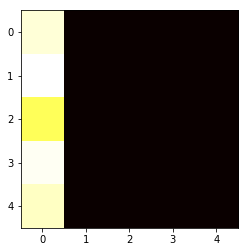

In [67]:
plt.imshow(results_svm[-1][1][5], cmap='hot', interpolation='nearest') 

<h2>Stochastic Gradient Descent</h2>
SGD is the second approach taken to classify the images. max_iter is set to 20 and alpha is set to 0.001 in the beginning. Then increased to 10^4. The "best" results were acquired when alpha was equal to 100.

Best result is still around 17.8% so it performs very poorly.

This can be trained to work with binary trainset. 

First the classifier is trained with the first 1000 images from the training set.

In [68]:
results_sgd.append(trainAndtest(X_trainos, y_trainos, 
                           X_testos, y_testos, 
                           createSGD(loss='hinge', alpha=100), pca=True, n_comp=32)) 

Started training
Loading 1000 images ...  Done
Applying PCA ...  Done
Training the model
Training complete, took 26.2353918552 seconds.
Started evaluation
Loading 1000 images ...  Done
Applying PCA ...  Done
Predicting test images ...  Done
Calculating performance metrics ...  Done


Model: SGDClassifier(alpha=100, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=20, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy:  0.178
Precision: 0.17842534124774923
Recall:    0.17797776747172278
F1:        0.17651596052844548
Kappa:     -0.027474313142171525
Confusion matrix:
[43 29 44 56 31]
[50 28 41 61 32]
[35 31 31 52 28]
[43 36 48 46 36]
[38 40 45 46 30]


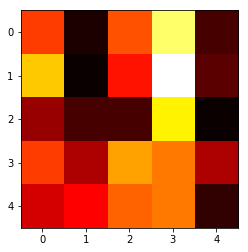

In [69]:
plt.imshow(results_sgd[-1][1][5], cmap='hot', interpolation='nearest') 

<h2>Random Forest Classifier</h2>
Random forest classifer is my third method. I tried different tree depths ranging between 2 to 20 and estimator amount ranging between 10 to 1000 to see how they perform.

It performed the best when the maximum depth is around 20. Due to performance and time issues I could set the number of estimators to 1000 to not too much.

Also PCA seems to reduce the accuracy of the classifier so its not used.

The best results are acquired from this classifier. It yield a 41% accuracy in the test set. Other metrics can be seen below.

In [70]:
results_rfc.append(trainAndtest(X_trainos, y_trainos, 
                           X_testos, y_testos, 
                           createRFC(max_depth=20, n_est=1000), pca=False, n_comp=32))  

Started training
Loading 1000 images ...  Done
Training the model
Training complete, took 70.2330429554 seconds.
Started evaluation
Loading 1000 images ...  Done
Predicting test images ...  Done
Calculating performance metrics ...  Done


Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.417
Precision: 0.41624503296844795
Recall:    0.41401346352582846
F1:        0.4083332283936052
Kappa:     0.27145308245326616
Confusion matrix:
[87 25 43 23 25]
[74 51 32 34 21]
[58 29 41 22 27]
[ 32  11  35 111  20]
[ 20   5  29  18 127]


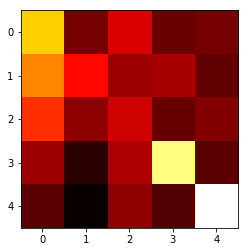

In [71]:
plt.imshow(results_rfc[-1][1][5], cmap='hot', interpolation='nearest') 

<h2>ADA Boost Classifier</h2>
Ada boost classifer is my fourth method. I tried different estimator amounts ranging between 50 to 1000 to see how they perform.

But this method took long enough for me to stop testing it. Changing the estimator amounts didn't really effect the accuracy as well.

In [72]:
results_ada.append(trainAndtest(X_trainos, y_trainos, 
                           X_testos, y_testos, 
                           createADA(), pca=False, n_comp=32)) 

Started training
Loading 1000 images ...  Done
Training the model
Training complete, took 1123.21483183 seconds.
Started evaluation
Loading 1000 images ...  Done
Predicting test images ...  Done
Calculating performance metrics ...  Done


Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None)
Accuracy:  0.267
Precision: 0.28121144126213504
Recall:    0.2674841862795504
F1:        0.2698463915343145
Kappa:     0.08542025126612529
Confusion matrix:
[46 42 55 36 24]
[71 39 44 40 18]
[51 36 47 22 21]
[45 18 49 71 26]
[36 10 51 38 64]


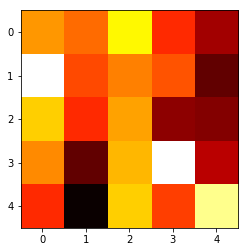

In [73]:
plt.imshow(results_ada[-1][1][5], cmap='hot', interpolation='nearest')  

<h2>Logistic Regression (One vs Rest)</h2>

LR is trained with binary labels (sick or not) rather than different stages of the illness.
Saga solver is being used instead of liblinear since it works faster in larger datasets. Also saga solver can be parallelized with n_jobs=-1, while liblinear cannot. (Though I came to realise saga has problems with multiprocessing as well).

C is adjusted after each run from 0.01 to 100, however the performance doesn't go beyond being random.

In [74]:
results_lr.append(trainAndtest(X_trainos_bin, y_trainos_bin, 
                          X_testos_bin, y_testos_bin, 
                          createLR(c=100.0, solver='saga', max_iter=100), pca=True, n_comp=32)) 

Started training
Loading 1000 images ...  Done
Applying PCA ...  Done
Training the model
Training complete, took 33.1287500858 seconds.
Started evaluation
Loading 1000 images ...  Done
Applying PCA ...  Done
Predicting test images ...  Done
Calculating performance metrics ...  Done


Model: LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy:  0.51
Precision: 0.5086070856371894
Recall:    0.5085921810551126
F1:        0.508566981317522
Kappa:     0.01719704597512106
Confusion matrix:
[228 249]
[241 282]


<h2>Convolutional Neural Network (An attempt)</h2>

A small sized CNN has been setup for classification. The layers used can be seen below. This classifier is the least tested among the 3. The competition participants acquired the highest accuracy using CNNs. So, after most parts of the pipeline is laid down properly, this method should work the best.

In [95]:
def createCNN():
    model = Sequential()
    
    model.add(Convolution2D(32, 3, 3, activation="relu", input_shape=(256, 512, 3)))
    model.add(Convolution2D(32, 3, 3, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    return model
    
def trainCNN(names, y, model):
    print "Loading",len(names),"images"
    X = range(len(names))
    for i in range(len(names)):
        X[i] = np.load(PAIR_PATH_RGB+"/"+names[i])
    X = np.array(X)
    y = np_utils.to_categorical(y, LABEL_COUNT)
    print "X shape", X.shape
    print "y shape", y.shape
    print "Loaded images. \nTraining model"
    model.fit(X, y, batch_size=32, nb_epoch=5, verbose=1) 
    print "Training complete"
    return model

def testCNN(names, y, model):
    X = range(len(names))
    for i in range(len(names)):
        X[i] = np.load(PAIR_PATH+"/"+names[i])
    y = np_utils.to_categorical(y, LABEL_COUNT)
    print "Loaded images. \nTraining model"
    return model.evaluate(X, y, verbose=0)

The CNN is created and tested below. There are no tests done on this so far. 

In [96]:
model = createCNN()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(256, 512,...)`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  """


In [ ]:
# TO DO: Fix Resource Problem
model = trainCNN(X_train[:100], y[:100], model)

Memory exhaustion errors weren't solved, thus, this code never actually ran.

<h1>Conclusion</h1><a href=#Outline>Go up</a>

Overall, the data is fairly explored and the images are prepared to be fed into different classification algorithms. Processing the images took the most time. Different classifiers will be tested for the best accuracy and Random Forest seems to yield the best results. So far, the images are directly fed into the algorithms. Principal component analysis is tried on the images. Some algorithms led to better results after PCA while some performed very poorly. Even a small set of images has shown that the resources are not enough. A test run with 10000 images took longer than an hour on almost all algorithms. So only 1000 images are used for training and testing. 

The data is extremely large to be processed on a desktop computer, unless days are spent on training the data. The difference between the images are so little that classifiers almost always peform very poorly under all circumstances. My understanding on the subject is also very limited even after a good amount of research. The features of the retina should be extracted with the guidiance of a medical doctor. 

<h3>System Specs</h3>
    - Python 2.7
    - OS:     Ubuntu 16.04
    - CPU:    Intel i7-6700
    - GPU:    Nvidia Gtx 970
    - Memory: DDR4 1600mhz 16gb

The End